ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

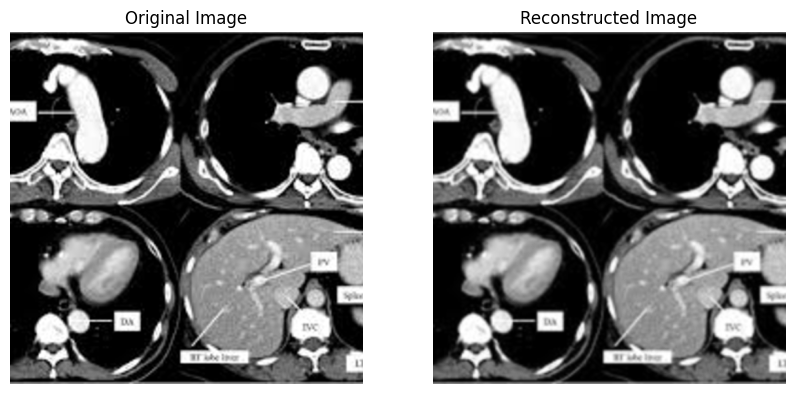

PSNR: 34.12832150540026 dB
SSIM: 0.9737552240995445


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

In [4]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    # Ensure audio can hold the data
    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    # Embed data into audio samples
    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    # Save modified audio
    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command)

# Load original image
original_image = cv2.imread('CT.png', cv2.IMREAD_GRAYSCALE)

# Resize image to 256x256
compressed_image = cv2.resize(original_image, (256, 256))

# Flatten image and shuffle pixels
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])  # Save original indices
np.random.shuffle(indices)  # Shuffle indices

shuffled_flat_image = flat_image[indices]  # Apply shuffle
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

# Save images
cv2.imwrite('compressed_CT.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT.png', shuffled_compressed_image)
np.save('shuffle_indices.npy', indices)  # Save indices for reconstruction

# Extract audio from video
video_file = 'input_video2.mp4'
audio_file = 'extracted_audio.wav'
extract_audio(video_file, audio_file)

# Embed the shuffled image into the extracted audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    # Extract data bits from audio samples
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]

    return np.array(data_bytes, dtype=np.uint8)

# Extract the shuffled image data from the audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Load shuffle indices
indices = np.load('shuffle_indices.npy')  # Load original shuffle indices

# Reverse the shuffling
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data  # Restore original order
reconstructed_image = reconstructed_flat.reshape((256, 256))

# Resize the reconstructed image back to original size
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))

# Save reconstructed image
cv2.imwrite('reconstructed_CT.png', reconstructed_image_resized)

# Calculate PSNR and SSIM
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images in Jupyter Notebook
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.show()

# Print PSNR and SSIM values
print(f"PSNR: {psnr_value} dB")
print(f"SSIM: {ssim_value}")

# Add the audio with embedded image back into the video
output_video_file = 'video_with_embedded_audio.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)


In [3]:
import matplotlib.pyplot as plt

# Values
sizes = [payload, unused]
labels = ['Payload Used', 'Unused Capacity']
colors = ['skyblue', 'lightgray']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, counterclock=False)
plt.title('Audio Capacity Usage', fontsize=14)
plt.axis('equal')  # Equal aspect ratio keeps circle

plt.show()



NameError: name 'payload' is not defined

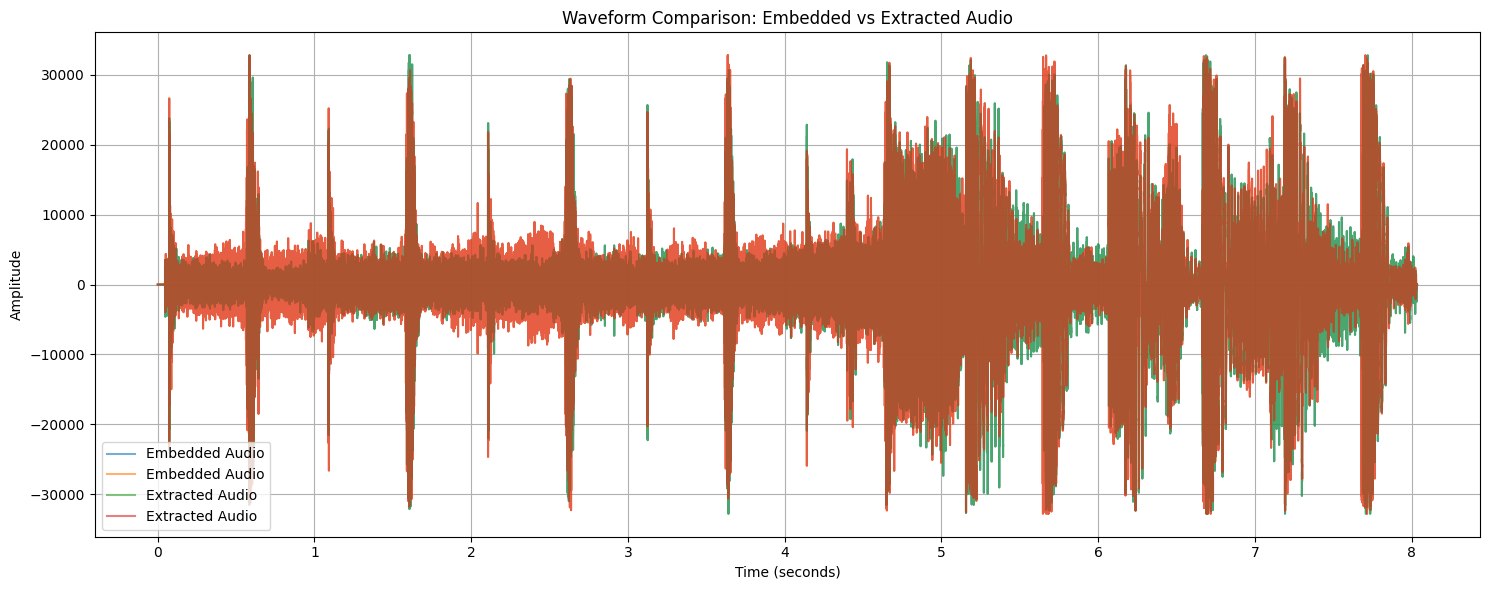

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

# Load embedded and extracted audio files
rate_embedded, embedded_audio = wav.read("audio_with_embedded_image1.wav")
rate_extracted, extracted_audio = wav.read("extracted_audio1.wav")

# Ensure both are mono (single channel) and same length
embedded_audio = embedded_audio[:min(len(embedded_audio), len(extracted_audio))]
extracted_audio = extracted_audio[:min(len(embedded_audio), len(extracted_audio))]
time = np.linspace(0, len(embedded_audio)/rate_embedded, num=len(embedded_audio))

plt.figure(figsize=(15, 6))
plt.plot(time, embedded_audio, label="Embedded Audio", alpha=0.6)
plt.plot(time, extracted_audio, label="Extracted Audio", alpha=0.6)
plt.title("Waveform Comparison: Embedded vs Extracted Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


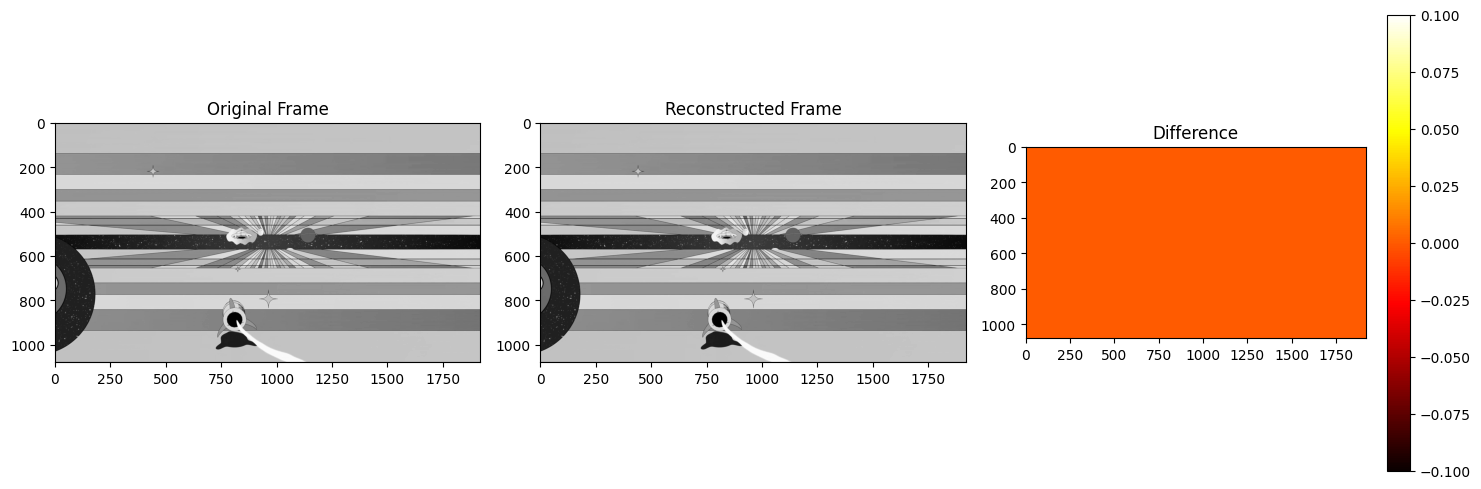

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def calculate_frame_difference(original_path, reconstructed_path, frame_index=0):
    cap1 = cv2.VideoCapture(original_path)
    cap2 = cv2.VideoCapture(reconstructed_path)

    cap1.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if not ret1 or not ret2:
        print("Error reading frame.")
        return

    # Convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Compute absolute difference
    diff = cv2.absdiff(gray1, gray2)

    # Show all side by side
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Frame")
    plt.imshow(gray1, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Frame")
    plt.imshow(gray2, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Difference")
    plt.imshow(diff, cmap='hot')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    cap1.release()
    cap2.release()

# Call the function
calculate_frame_difference("input.mp4", "video_with_embedded_audio1.mp4", frame_index=100)


In [12]:
# Compute Pearson Correlation Coefficient
from scipy.stats import pearsonr

# Flatten both images to 1D
original_flat = original_image.flatten()
reconstructed_flat = reconstructed_image_resized.flatten()

# Calculate Pearson correlation
pearson_corr, _ = pearsonr(original_flat, reconstructed_flat)

# Print Pearson correlation
print(f"Pearson Correlation Coefficient: {pearson_corr}")


Pearson Correlation Coefficient: 0.9984240271733346


In [19]:
import time

# ------------------------------
# Embed the shuffled image into the extracted audio WITH TIMING
# ------------------------------
start_embed = time.time()

shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image1.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

end_embed = time.time()
embedding_time = end_embed - start_embed
print(f"Embedding Time: {embedding_time:.4f} seconds")

# ------------------------------
# Extract the shuffled image data from the audio WITH TIMING
# ------------------------------
start_extract = time.time()

extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

end_extract = time.time()
extraction_time = end_extract - start_extract
print(f"Extraction Time: {extraction_time:.4f} seconds")


Embedding Time: 0.1735 seconds
Extraction Time: 0.1000 seconds
